# MI2 - ES06: ICA2, Noise and Kurtosis
## The chantastic 4: Elisabeth Kress, Paola Suárez, Jianmeng Wu and Esra Zihni

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Simulated annealing

### Initialization

In [172]:
# Helper functions
def energy_i(i, W, states):
    Es = np.sum([W[i,j]*states[i]*states[j] for j in range(N) if j != i]) / -2
    Es_ = -Es
    delta = Es_ - Es
    return Es, Es_, delta

def to_flip(delta, beta, state_i):
    prob2flip = (1 + np.exp(beta * delta))**-1
    compare = np.random.rand()
    if compare < prob2flip:
        state_i = -state_i
    return state_i, prob2flip

In [183]:
# Parameters
beta0 = 1.5
tau = 1.01 # Exponential annealing tau in [1.01, 1.3]
t_max = 500
N = 6  # Nodes

# Network with 6 nodes, s in {-1, 1}
# Do we need to initialize some states or do we need to consider all 2**6 possibilities
states = np.random.randint(0, 2, size=N)
states[states==0] = -1

# Weight matrix: arbitrary, symmetric(ij=ji) and zero diagonal
W = np.random.uniform(-1, 1, (N, N))
W = (W + W.T)/2
np.fill_diagonal(W, 0)

### Optimization

In [214]:
betas = np.zeros(t_max+1)
betas[0] = beta0

energies = np.zeros((t_max, N, 2))
probs = np.zeros(t_max)

for t in range(t_max):
    M = 500  # Times to update state, play with M = 1 and M = 500
    beta = betas[t]
    # State update loop
    while M != 0:
        M -= 1
        # Select node
        node_idx = np.random.randint(0, 6)

        # Calculate energy and difference
        Es, Es_, deltaE = energy_i(node_idx, W, states)
        energies[t,node_idx,0] = Es
        energies[t,node_idx,1] = Es_

        # Flip
        states[node_idx], probs[t] = to_flip(deltaE, beta, states[node_idx])
    
    # Update beta
    betas[t+1] = tau * beta

### Plotting

$\beta$

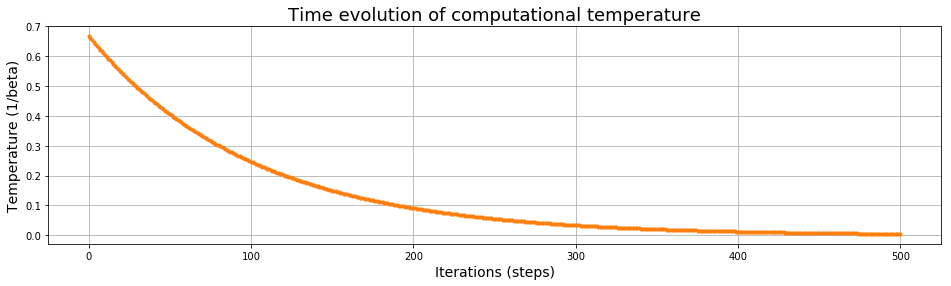

In [215]:
plt.figure(figsize=(16, 4))
plt.plot(range(t_max+1), 1/betas, ".-C1")
plt.title("Time evolution of computational temperature", size=18)
plt.xlabel("Iterations (steps)", size=14)
plt.ylabel("Temperature (1/beta)", size=14)
plt.grid()
plt.show()

In [216]:
# Energy across all nodes for one state
Energy = np.sum(energies[:,:,0], axis=1)

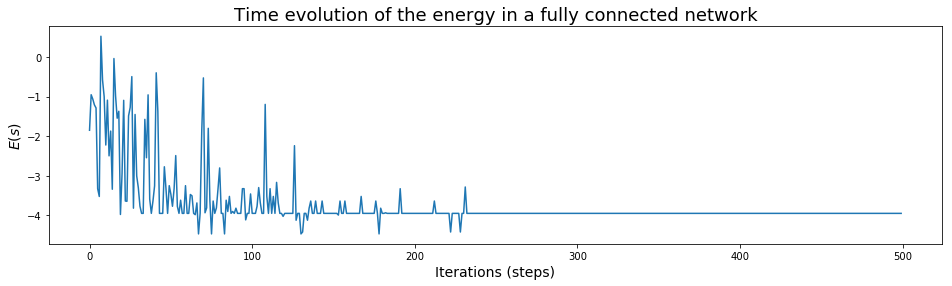

In [217]:
plt.figure(figsize=(16, 4))
plt.plot(range(t_max), Energy) #, label="node %i" %(n+1))
plt.title("Time evolution of the energy in a fully connected network", size=18)
plt.xlabel("Iterations (steps)", size=14)
plt.ylabel("$E(s)$", size=14)
plt.show()

In [171]:
# Trying to plot the enregies for all 2**6 states
# The try failed.
#plt.figure()
#plt.bar([energies[:,n,s] for n in range(N), for s in [0, 1]])
#plt.show()

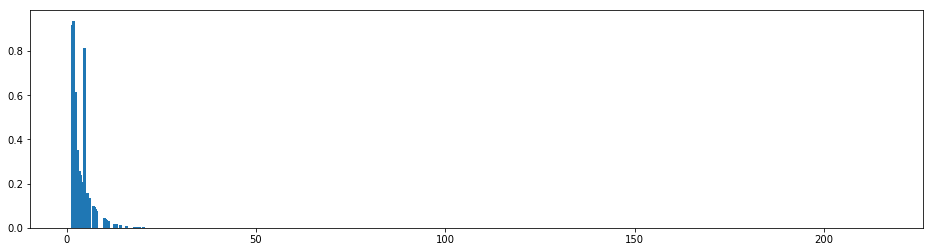

In [218]:
plt.figure(figsize=(16,4))
plt.bar(betas[:-1], probs)
plt.show()

## 2. Mean-field annealing

## Discussion

### Compare the required number of iterations until convergence:

### Compare the total runtime (in dependence of different choices of $M$, $\tau$ , $\epsilon$)

### Compare the final result s after iteration $t_{max}$

In [221]:
print("Final state after simulated annealing:")
print("%s" %states)

Final state after simulated annealing:
[-1 -1  1 -1 -1 -1]
